# Decoding with Ambiguity Clustering

In this notebook, we demonstrate decoding with Riverlane's proprietary decoder: the [Ambiguity Clustering (AC) decoder](https://www.nature.com/articles/s41586-024-07107-7). In particular, we

* generate a circuit for a surface code quantum memory experiment, define a noise model, and generate measurement and detector data from the circuit with the noise model applied;
* decode the detector data with both AC and Pymatching (MWPM), and show that AC can achieve a better logical error probability;
* generate a stim circuit implementation of IBM's 72-qubit bivariate bicycle code to generate measurement and detector data;
* decode this data with both AC and BP-OSD to show that AC can decode much faster whilst maintaining a similar logical error probability.

## Introduction

Ambiguity Clustering (AC) is a prototype decoding algorithm for general qLDPC codes being developed by Riverlane. The purpose of this notebook is to demonstrate the decoder's capability decoding a surface code, benchmarking its performance against the [minimum weight perfect matching](https://arxiv.org/pdf/2105.13082) (MWPM) decoder. Then, we look at its performance on a qLDPC code ([IBM's 72-qubit bivariate bicycle code](https://arxiv.org/pdf/2308.07915)), and compare its performance with the [BP-OSD](https://github.com/quantumgizmos/bp_osd) decoder.

Unlike 'matching' decoders such as MWPM (e.g. Pymatching), which operate on decoding *graphs* (that is, each error mechanism must trigger at most two checks), Ambiguity Clustering operates on a more general structure, the decoding *hypergraph* - or in other words, any Stim detector error model (DEM). This makes it suitable for decoding any QEC code for which a detector error model can be generated, including qLDPC codes.

Even for the surface code, whose DEM can be well-approximated as a decoding graph so that we can run MWPM on it, AC can still potentially provide a logical fidelity gain over matching decoders, as by considering the full hypergraph it is able to 'see' correlations between Pauli X and Pauli Z errors occurring on qubits, to which MWPM is blind (unless you use a correlated matching technique). We demonstrate this accuracy gain here for a distance-7 surface code memory experiment.

We then generate a stim circuit of IBM's 72-qubit bivariate bicycle code using the Deltakit API, and then decode with AC, demonstrating AC's superior speed with comparable accuracy to BP-OSD.

### How it works

AC is a two phase algorithm. First, like BP-OSD, it runs the belief propagation graphical inference algorithm on the decoding Tanner graph to get an approximate probability of occurrence for every error mechanism. Secondly, it applies a series of linear algebra operations to the parity check matrix to identify connected clusters of syndrome bits in the Tanner graph. It can then search over solutions to these clusters individually to find the most likely solutions to the syndrome.

## Preparation
### Perform all necessary imports

In [1]:
# Import prerequisites
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import stim
from deltakit.explorer import Client
from deltakit.explorer.enums import DecoderType
from deltakit.explorer.types import Decoder, PhysicalNoiseModel, QECExperimentDefinition

In [2]:
Client.set_token('8RmM5v8pUDPCew9SijMYQbXpYK5SHX2l')
client = Client.get_instance()
example_circuits_folder = Path("../..") / "data/examples/qldpc"

## Generate Surface Code Data
We generate data for rotated planar codes of distances 3, 5, 7, with the number of rounds of syndrome extraction matching the distance. We use a circuit-level noise model with p=0.5% for all the noise parameters. Gate times, T1 and T2 times allow to compute idleness durations and apply realistic idleness noise. For more details see the {ref}`client-add-noise-to-the-circuit` example.

In [3]:
from deltakit.circuit.gates import PauliBasis, CZ, H, MZ, RZ
from deltakit.explorer.codes import RotatedPlanarCode, css_code_memory_circuit
from deltakit.explorer.qpu import QPU, NativeGateSet, PhysicalNoise
from deltakit_explorer.simulation import simulate_with_stim

# How many shots to run
num_shots = 10000
distances = [3, 5, 7]

# Define p = 0.5% noise model
noise_model = PhysicalNoise(
    t_1=50e-6,
    t_2=50e-6,
    p_1_qubit_gate_error=0.002,
    p_2_qubit_gate_error=0.002,
    p_reset_error=0.002,
    p_meas_qubit_error=0.002,
    p_readout_flip=0.002
)

native_gates = NativeGateSet(
    one_qubit_gates=[H],
    two_qubit_gates=[CZ],
    measurement_gates=[MZ],
    reset_gates=[RZ]
)

# `from_times` was written as a method of NativeGateSetAndTimes
# NativeGateSet inherits it, apparently
# Maybe it should have been `add_times` and it is invoked on a `NativeGateSet`, 
# possibly an `ExhaustiveGateSet` if specific gates aren't to be specified
native_gates_times = NativeGateSet.from_times(
    time_1_qubit_gate=50e-9,
    time_2_qubit_gate=100e-9,
    time_measurement=500e-9,
    time_reset=500e-9,
    native_gates=native_gates
)

# Generate noiseless circuits
compiled_circuits = []
measurements_files = []
for distance in distances:
    code = RotatedPlanarCode(distance, distance)
    # is num_rounds=distance right?
    ideal_circuit = css_code_memory_circuit(code, num_rounds=distance, logical_basis=PauliBasis.Z)
    # can I make qubits an optional argument of QPU? We're always passing the circuit's qubits
    qpu = QPU(ideal_circuit.qubits, native_gates_and_times=native_gates_times, noise_model=noise_model)
    compiled_circuit = qpu.compile_and_add_noise_to_circuit(ideal_circuit)
    compiled_circuits.append(compiled_circuit)
    
    # Simulate noisy circuit to generate measurement data
    measurements, _ = simulate_with_stim(
        stim_circuit=compiled_circuit.as_stim_circuit(),  # shouldn't require conversion to `stim`
        shots=num_shots
    )
    measurements_files.append(measurements)

## Decoding the surface code data with MWPM

In [4]:
import numpy as np
from deltakit.explorer.analysis import calculate_lep_and_lep_stddev
from deltakit.decode import MWPMDecoder

mwpm_errors = []
mwpm_error_bars = []

# Loop through the circuits and perform MWPM decoding on each
for compiled_circuit, measurements in zip(compiled_circuits, measurements_files):
    detection_events, logical_flips = measurements.to_detectors_and_observables(compiled_circuit.as_stim_circuit())
    decoder = MWPMDecoder(compiled_circuit, client=client)
    predicted_flips = decoder.decode_batch_to_logical_flip(detection_events.as_numpy(), parallel_jobs=8)
    shots = predicted_flips.size
    fails = np.count_nonzero(logical_flips.as_numpy() != predicted_flips)
    lep, std_deviation = calculate_lep_and_lep_stddev(fails, shots)
    mwpm_errors.append(lep)
    mwpm_error_bars.append(std_deviation)

## Decoding the surface code data with AC
We see that although AC takes longer to decode per shot than MWPM, it can achieve a lower logical error probability (note there is significant variance per run). This is because it operates on the whole, undecomposed, detector error model, and so can 'see' correlations between X and Z errors.

In [5]:
from deltakit.decode import ACDecoder

ac_errors, ac_error_bars = [], []
kappa = 0.02
# Loop through the circuits and perform AC decoding on each
for distance, compiled_circuit, measurements in zip(distances, compiled_circuits, measurements_files):
    detection_events, logical_flips = measurements.to_detectors_and_observables(compiled_circuit.as_stim_circuit())
    parameters = {
        "decompose_errors": False,
        "bp_rounds": distance,
        "ac_kappa_proportion": kappa,
    }
    decoder = ACDecoder(compiled_circuit, parameters=parameters, client=client)
    predicted_flips = decoder.decode_batch_to_logical_flip(detection_events.as_numpy(), parallel_jobs=8)
    shots = predicted_flips.size
    fails = np.count_nonzero(logical_flips.as_numpy() != predicted_flips)
    lep, std_deviation = calculate_lep_and_lep_stddev(fails, shots)
    ac_errors.append(lep)
    ac_error_bars.append(std_deviation)

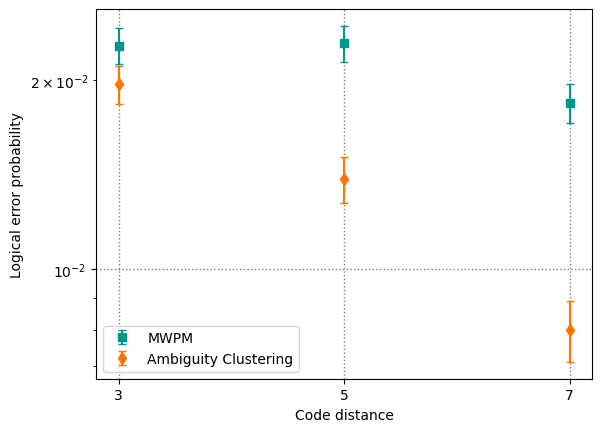

In [6]:
plt.errorbar(distances, mwpm_errors, yerr = mwpm_error_bars, color="#00968f", capsize = 3, label = "MWPM", fmt = 's')
plt.errorbar(distances, ac_errors, yerr = ac_error_bars, color="#ff7500", capsize = 3, label = "Ambiguity Clustering", fmt = 'd')
plt.grid(color="gray", linestyle=":", linewidth=1)
plt.xticks(distances)
plt.xlabel("Code distance")
plt.ylabel("Logical error probability")
plt.yscale('log')
plt.legend()

## Decoding qLDPC codes
Quantum low-density parity check (qLDPC) codes are the current leading family of error correcting codes. These codes allow for the possibility of fault-tolerant quantum computation with lower overheads (fewer physical qubits needed per encoded logical qubit) compared to conventional codes, such as the surface code.

We will deal with one such qLDPC code, IBM's 72-qubit bivariate bicycle code, which makes use of 72 physical qubits to encode 12 logical qubits, and has a distance of 6. This gives it code parameters [[72, 12, 6]]. 

### Read-in circuit
Here we use a Stim circuit implementing the 72-qubit code at a 0.5% physical error rate (generated using a script from [Gong et al.](https://arxiv.org/pdf/2403.18901); repo [here](https://github.com/gongaa/SlidingWindowDecoder)). The noise model is a realistic noise model for superconducting qubits. Parameters are listed below.

In [19]:
from deltakit.explorer.codes import BivariateBicycleCode
from deltakit.explorer.qpu import SI1000Noise

# Code parameters, for naming files
code_name = "[[72,12,6]]"
param_l = 6
param_m = 6
m_A_powers = [3, 1, 2]
m_B_powers = [3, 1, 2]
code = BivariateBicycleCode(param_l, param_m, m_A_powers, m_B_powers, validate=True)

# This is not the same superconducting noise model; that one can easily be implemented
# using `PhysicalNoise`
noise_model = SI1000Noise(p=0.005)

# generate, compile, and add noise to circuit
# IIRC the circuit in the file has unnecessary elements stripped away, 
# making it smaller and easier to decode? Can we do that with `deltakit`?
ideal_circuit = css_code_memory_circuit(code, num_rounds=distance, logical_basis=PauliBasis.Z)
qpu = QPU(ideal_circuit.qubits, native_gates_and_times=native_gates_times, noise_model=noise_model)
noisy_circuit = qpu.compile_and_add_noise_to_circuit(ideal_circuit)

### Simulate measurements, generate detectors and observables

In [20]:
num_shots = 1000

# Simulate noisy circuit to generate measurement data
measurements, _ = simulate_with_stim(
    stim_circuit=noisy_circuit,
    shots=num_shots,
    client=client,
)

# Convert the measurement data to detectors and observables
detection_events, logical_flips = measurements.to_detectors_and_observables(
    stim_circuit=noisy_circuit.as_stim_circuit(),
)

### Decode with AC and BP-OSD

Here we demonstrate decoding of IBM's 72 qubit bivariate bicycle code with AC, and, for comparison, with BP-OSD.
These BP parameters for the two algorithms are empirically found to work well. Since BP-OSD has a much heavier post-processing step than AC, it makes sense that the algorithm benefits from more rounds of BP.

In our example, we demonstrate AC's superior decoding time compared to BP_OSD, whilst maintaining a comparable logical error rate.

In [21]:
from deltakit.decode import BPOSDecoder

parameters={"decompose_errors": False, "bp_rounds": 99, "ac_kappa_proportion": 0.02}
decoder_ac = ACDecoder(noisy_circuit, parameters=parameters, client=client)

parameters={"decompose_errors": False, "max_bp_rounds": 10_000, "combination_sweep_order": 0}
decoder_bpos = BPOSDecoder(noisy_circuit, parameters=parameters, client=client)

decoders = [decoder_ac, decoder_bpos]

In [22]:
from time import perf_counter
leps = []
times = []
for decoder in decoders:
    print(f"Decoding {code_name} code with {decoder.__class__.__name__}.")
    predicted_flips = decoder.decode_batch_to_logical_flip(detection_events.as_numpy(), 
                                                           parallel_jobs=8)

    shots = predicted_flips.size
    fails = np.count_nonzero(logical_flips.as_numpy() != predicted_flips)
    lep, std_deviation = calculate_lep_and_lep_stddev(fails, shots)

Decoding [[72,12,6]] code with ACDecoder.
Decoding [[72,12,6]] code with BPOSDecoder.


[2025-09-11 22:25:25,318.318][deltakit-explorer][ERROR] decode: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')) | reqid=[db9d26b672c94e6e99ff19801b8bf2ff]


ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [ ]:
# to be translated after resolving the error above

print("\n Decoder | Logical error probability | Total CPU time (all cores), s")
print("-" * 69)
for decoder, result in decoding_results.items():
    decoding_time = sum(result.times)
    print(f" {decoder.value:7s} | {result.get_logical_error_probability():25.2} |\t\t{decoding_time:.4f}")